## putting files in Blur_output into AVA Featuremaps

In [1]:
import os
import io
import time
import pickle
import bz2
import pandas as pd
import numpy as np
import shutil

import cv2 as cv
from skimage import transform
import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP

from Datasets import *

image_dir = r"C:\Users\Leo's PC\Desktop\images"
feature_dir = r"I:\AVA Featuremaps"
csv_dir = r"C:\Users\Leo's PC\Desktop\AVA.txt"
checkpoint_save_dir = r"C:\Users\Leo's PC\PycharmProjects\PD\Model Checkpoints"

In [7]:
def moveBlur2AVA(blurpath, avapath):
    counter = 0
    img_list = os.listdir(avapath)
    
    for img in img_list:

        try:
            blur = cv.imread(os.path.join(blurpath, str(img) + '.png'), cv.IMREAD_UNCHANGED)
        except:
            print('Blur map reading error/not found. Skipped. File is:', os.path.join(blurpath, str(img) + '.png'))
        else:
            blue, green, red = cv.split(blur)
            
            cv.imwrite(os.path.join(avapath, str(img), '17.jpg'), blue)
            cv.imwrite(os.path.join(avapath, str(img), '18.jpg'), green)
            cv.imwrite(os.path.join(avapath, str(img), '19.jpg'), red)
            
            counter += 1
            
    print('Moving completed. Total:', counter)
    
    return counter

In [2]:
moveBlur2AVA(blurpath=r'I:\blurmap', avapath=r'I:\AVA Featuremaps')

Moving completed. Total: 255502


255502

COCO_PERSON_KEYPOINT_NAMES = [
                    'nose',
                    'left_eye',
                    'right_eye',
                    'left_ear',
                    'right_ear',
                    'left_shoulder',
                    'right_shoulder',
                    'left_elbow',
                    'right_elbow',
                    'left_wrist',
                    'right_wrist',
                    'left_hip',
                    'right_hip',
                    'left_knee',
                    'right_knee',
                    'left_ankle',
                    'right_ankle'
                    ]
        
What is the output data structure for Keypoint RCNN's keypints? Where is the value specifying the keypoint category?
What are the values returned by EmoNet? One-hot or single value? 0-6 or 1-7?

In [94]:
class EmoNet(nn.Module):
    def __init__(self):
        super(EmoNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=[7,7], stride=1, padding=3)
        self.bn2d1 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.activation1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=[3,3], stride=1, padding=1)
        self.bn2d2 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.activation2 = nn.ReLU()
        
        self.pool1 = nn.MaxPool2d(kernel_size = [3, 3], stride=3, padding=1)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=[3,3], stride=1, padding=1)
        self.bn2d3 = nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.activation3 = nn.ReLU()
        
        self.pool2 = nn.MaxPool2d(kernel_size = [3, 3], stride=3, padding=1)
        
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=[3,3], stride=1, padding=1)
        self.bn2d4 = nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.activation4 = nn.ReLU()
        
        self.pool3 = nn.MaxPool2d(kernel_size = [3, 3], stride=3, padding=1)
        
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=[2,2], stride=2, padding=0)
        self.bn2d5 = nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.activation5 = nn.ReLU()

        
        self.fc1 = nn.Linear(512, 512)
        self.bn1d1 = nn.BatchNorm1d(512)
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 256)
        self.bn1d2 = nn.BatchNorm1d(256)
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(256, 7)

        
        self.ReLU = nn.ReLU()
        self.Sigmoid = nn.Sigmoid()
        self.Tanh = nn.Tanh()
        self.Softmax = nn.Softmax(dim=1)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.bn2d1(x)
        x = self.activation1(x)

        x = self.conv2(x)
        x = self.bn2d2(x)
        x = self.activation2(x)
        
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.bn2d3(x)
        x = self.activation3(x)
        
        x = self.pool2(x)
        
        x = self.conv4(x)
        x = self.bn2d4(x)
        x = self.activation4(x)
        
        x = self.pool3(x)

        x = self.conv5(x)
        x = self.bn2d5(x)
        x = self.activation5(x)
        
        x = x.view(x.size()[0], -1)

        x = self.fc1(x)
        x = self.bn1d1(x)
        x = self.dropout1(x)
        x = self.Tanh(x)
        
        x = self.fc2(x)
        x = self.bn1d2(x)
        x = self.dropout2(x)
        x = self.Tanh(x)
        
        x = self.fc3(x)
        x = self.Softmax(x)
        
        return x
    
    
KeypointRCNN = torchvision.models.detection.keypointrcnn_resnet50_fpn(pretrained=True, progress=True, num_classes=2, num_keypoints=17, pretrained_backbone=True)
EmoNet = EmoNet()

KeypointRCNN.eval()
KeypointRCNN.to(torch.device('cuda:0'))

EmoNet.eval()
EmoNet.to(torch.device('cuda:1'))

EmoNet(
  (conv1): Conv2d(1, 32, kernel_size=[7, 7], stride=(1, 1), padding=(3, 3))
  (bn2d1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation1): ReLU()
  (conv2): Conv2d(32, 64, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (bn2d2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation2): ReLU()
  (pool1): MaxPool2d(kernel_size=[3, 3], stride=3, padding=1, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (bn2d3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation3): ReLU()
  (pool2): MaxPool2d(kernel_size=[3, 3], stride=3, padding=1, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=[3, 3], stride=(1, 1), padding=(1, 1))
  (bn2d4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (activation4): ReLU()
  (pool3): MaxPool2d(kernel_size=[3, 3

In [92]:
def infer4person(face_pkl_path, AVA_path, KeypointRCNN_model, Emo_model):
    
    def infer_Emo(img, face_data):
        '''
        return [[x,x,y,y,emo_category], ...]
            - shape == [num_faces, 5]
        '''
        
        def infer(model, img, device):

            def to_variable(x,requires_grad=True):
                if torch.cuda.is_available():
                    x = x.cuda()
                return Variable(x,requires_grad)

            to_tensor = transforms.ToTensor()

            img = cv.resize(img, (48, 48))
            img = to_tensor(img)
            img = to_variable(img.unsqueeze(0), False)
            img = img.cuda()
            img = img.to(torch.device(device))
            out = model(img)
            return out
    
        for face in face_data:
            facelocation = [int(i) for i in face]
            croped_img = img[facelocation[1]:facelocation[3], facelocation[0]:facelocation[2]]
            croped_img = cv.cvtColor(croped_img, cv.COLOR_BGR2GRAY)
            croped_img = np.expand_dims(croped_img, axis=2)

            out = infer(model=Emo_model, img=croped_img, device='cuda:1')
            result = np.argmax(out.cpu().detach())
            face = np.append(face, result)
        return face_data
    
    def infer_KeypointRCNN(img, threshold = 0.93, kpt_score_threshold = 5):
        '''
        return [[[x, y], ...], ...]
            - shape = [17, numbers of pointes detected for that category, 2]
        '''
        
        def infer(model, img, device):
        
            def to_variable(x,requires_grad=True):
                if torch.cuda.is_available():
                    x = x.cuda()
                return Variable(x,requires_grad)

            to_tensor = transforms.ToTensor()

            img = to_tensor(img)
            img = to_variable(img.unsqueeze(0), False)
            img = img.cuda()
            img = img.to(torch.device(device))
            out = model(img)
            return out
        
        predictions = infer(model=KeypointRCNN_model, img=img, device='cuda:0')
        
        out = [[None]] * 17       
        box_idx = 0
        
        for dot_group in predictions[0]['keypoints']:
            point_idx = 0
            for dot in dot_group:
                if predictions[0]['keypoints_scores'][box_idx][point_idx] >= kpt_score_threshold and predictions[0]['scores'][box_idx] >= threshold:
                    category_out.insert(len(category_out), [dot[0].cpu().detach().numpy(), dot[1].cpu().detach().numpy()])
                point_idx += 1
            out[box_idx] = category_out
            box_idx += 1
        
        return out
        
        
    def make_img(face_out, KeypointRCNN_out, shape):
        '''
        return
            [cv image]
        shape
            24: 7+17
        '''
        out = [np.zeros((shap[0], shape[1]), np.uint8)] * 24
        
        for face in face_out:
            out[face[4]] = cv.rectangle(out[face[4]], (facelocation[0], facelocation[1]), 
                                        (facelocation[2], facelocation[3]), color=255, thickness=-1)
        for category_idx, points in enumerate(KeypointRCNN_out):
            for point in points:
                out[category_idx + 7] = cv.circle(out[category_idx + 7], center=point, 
                                                  radius=2, color=255, thickness=-1)
        return out
    
    def save_output(images):
        
        for idx, image in enumerate(images):
            cv.imwrite(os.path.join(avapath, str(img), str(idx + 20) + '.jpg'), blue)
    
    
    with open(face_pkl_path, 'rb') as fp:
        face_dict = pickle.load(fp, encoding='latin1')
        
    print(len(face_dict), "images to be processed.")
    
    idx = 0
    for img_name, faces in face_dict.items():
        if faces != [] and os.path.exists(os.path.join(os.path.join(AVA_path, str(img_name), '0.jpg'))):
            image = cv.imread(os.path.join(AVA_path, str(img_name), '0.jpg'), cv.IMREAD_UNCHANGED)
            
            face_out = infer_Emo(img=image, face_data=faces)
            KeypointRCNN_out = infer_KeypointRCNN(img=image)
        
            output_images = make_img(face_out, KeypointRCNN_out)
            
            save_output(output_images)
            print()
            
            idx += 1
            if idx % 1000 == 0:
                print(idx, 'images(with face) processed.')

In [95]:
device = 'cuda:0'
infer4person(face_pkl_path=r'face_out.pkl', AVA_path=r"I:\AVA Featuremap Dummy", KeypointRCNN_model=KeypointRCNN, Emo_model=EmoNet)

255508 images to be processed.


RuntimeError: No such operator torchvision::nms

In [25]:
testimage = cv.imread(os.path.join('I:\AVA Featuremaps', str(101392), '0.jpg'), cv.IMREAD_UNCHANGED)
print(testimage.shape)
cv.imshow('raw', testimage)
cv.waitKey(0) 
facelocation = face_out['101392'][0]
facelocation = [int(i) for i in facelocation]
print(facelocation)
cropped_img = testimage[facelocation[1]:facelocation[3], facelocation[0]:facelocation[2]]
cv.imshow('test', cropped_img)
cv.waitKey(0) 

(640, 640, 3)


NameError: name 'face_out' is not defined

(array([ 124.,  201., 1007.,  644., 1530., 2621., 1269.,  422.,  485.,
         155.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

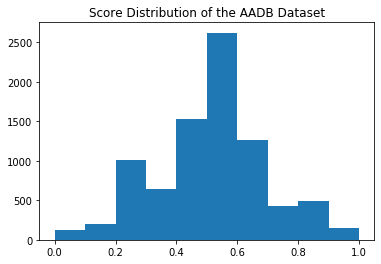

In [71]:
AADB = pd.read_csv('H:\AADB\imgListTrainRegression_score.csv', sep=' ')

stats = []
for idx, row in AADB.iterrows():
    stats.append(row[1])

plt.title('Score Distribution of the AADB Dataset')
plt.hist(stats)

In [3]:
with open('./2048nodes.pkl', 'rb') as fp:
    scene = pickle.load(fp)

In [7]:
print(scene[10012])

[0.02148148 0.09121222 0.07329814 ... 0.01226436 0.04519626 0.12901092]


In [5]:
a = np.array([1, 2, 3])
print(a)

[1 2 3]


In [6]:
print(a.shape)

(3,)


In [16]:
num_list = np.random.rand(100)
sum_list = np.random.rand(30)

for idx, i in enumerate(num_list):
    i = int(3000*i)
    num_list[idx] = i

for idx, i in enumerate(sum_list):
    i = int(10000*i)
    num_list[idx] = i 

In [18]:
print(num_list)

[6.274e+03 8.400e+03 5.900e+01 1.493e+03 8.159e+03 8.783e+03 2.356e+03
 1.000e+00 5.714e+03 5.898e+03 9.390e+03 5.900e+03 7.672e+03 9.228e+03
 4.235e+03 6.800e+02 2.482e+03 3.854e+03 1.040e+02 7.152e+03 8.379e+03
 9.008e+03 6.877e+03 1.712e+03 3.070e+03 1.724e+03 8.236e+03 2.496e+03
 1.470e+02 9.064e+03 2.292e+03 5.260e+02 2.075e+03 6.700e+02 1.968e+03
 2.809e+03 1.996e+03 3.410e+02 1.874e+03 9.230e+02 3.260e+02 1.356e+03
 1.164e+03 1.003e+03 2.560e+03 7.100e+02 1.000e+01 2.163e+03 2.347e+03
 8.700e+01 3.550e+02 7.300e+02 1.328e+03 3.890e+02 1.367e+03 1.591e+03
 2.288e+03 1.962e+03 1.698e+03 1.646e+03 6.450e+02 8.460e+02 1.804e+03
 1.086e+03 9.690e+02 4.670e+02 3.620e+02 1.007e+03 1.904e+03 1.057e+03
 2.421e+03 1.935e+03 2.619e+03 7.290e+02 1.081e+03 2.178e+03 1.601e+03
 2.842e+03 9.770e+02 2.332e+03 1.851e+03 2.981e+03 6.810e+02 2.806e+03
 1.860e+02 2.230e+03 2.693e+03 2.771e+03 2.094e+03 8.380e+02 1.125e+03
 2.245e+03 1.496e+03 1.410e+02 2.071e+03 6.160e+02 2.057e+03 2.151e+03
 5.580

In [1]:
from numba import njit

@njit
def useless():
    print('start')
    for i in range(5000000000000000000):
        if i==1:
            print('wow')

In [14]:
from sys import getsizeof

sampleimage = cv.imread(os.path.join(r'I:\AVA Featuremap Dummy\541', '1.jpg'), cv2.IMREAD_UNCHANGED)

In [15]:
print(getsizeof(sampleimage) / 1000)

307.312


In [12]:
print(sampleimage)

[[[168 168 162]
  [ 40  31  17]
  [150 121  94]
  ...
  [  0   1   0]
  [  2   0   0]
  [  4   2   1]]

 [[169 168 164]
  [ 40  31  18]
  [151 121  92]
  ...
  [  3   4   2]
  [  4   2   2]
  [  3   1   0]]

 [[169 167 166]
  [ 42  30  18]
  [153 121  92]
  ...
  [  4   4   4]
  [  2   1   3]
  [  0   0   0]]

 ...

 [[166 168 176]
  [116 118 126]
  [ 93  95 103]
  ...
  [ 78 100 125]
  [ 45  63  86]
  [ 69  88 109]]

 [[159 161 169]
  [114 116 124]
  [110 112 120]
  ...
  [ 53  73 104]
  [ 98 114 143]
  [ 70  87 114]]

 [[163 165 173]
  [112 114 122]
  [115 117 125]
  ...
  [ 60  79 112]
  [ 49  64  96]
  [ 80  95 127]]]


In [34]:
def PickleAVAFeaturemaps(avapath, outputpath):
    counter = 0
    img_list = os.listdir(avapath)
    
    for img_name in img_list:
        imagelist = []
        
        for i in range(20):
            img = cv.imread(os.path.join(avapath, str(img_name), str(i) + '.jpg'), cv.IMREAD_UNCHANGED)
            imagelist.append(img)
        
        with open(os.path.join(outputpath, str(img_name) + '.pkl'), 'wb') as fp:
            pickle.dump(imagelist, fp)
        
        counter += 1
        if counter % 10000 == 0:
            print(counter, 'img:', img_name)
        
    print('Moving completed. Total:', counter)
    
    return counter

In [35]:
PickleAVAFeaturemaps(avapath=r'I:\AVA Featuremaps', outputpath=r'H:\AVAFeatures_pkl')

10000 img: 127778
20000 img: 160494
30000 img: 1942
40000 img: 233092
50000 img: 267305
60000 img: 300195
70000 img: 332225
80000 img: 368366
90000 img: 404999
100000 img: 4392
110000 img: 472305
120000 img: 506203
130000 img: 546811
140000 img: 5916
150000 img: 628331
160000 img: 66281
170000 img: 694368
180000 img: 732136
190000 img: 763032
200000 img: 791038
210000 img: 824514
220000 img: 8533
230000 img: 886860
240000 img: 919561
250000 img: 946724
Moving completed. Total: 255502


255502

In [26]:
training_stats_Aug = torch.load(open(r"I:\Model Checkpoints\DenseNet_Augmented_Binary_Paper_E19A868_10.12.2020_04.44.35.tar", 'rb'))
training_stats_Base = torch.load(open(r"I:\Model Checkpoints\DenseNet_Baseline_10%_paper_E19A858_10.12.2020_19.14.45.tar", 'rb'))

training_stats_Aug = training_stats_Aug['training_stats']
training_stats_Base = training_stats_Base['training_stats']

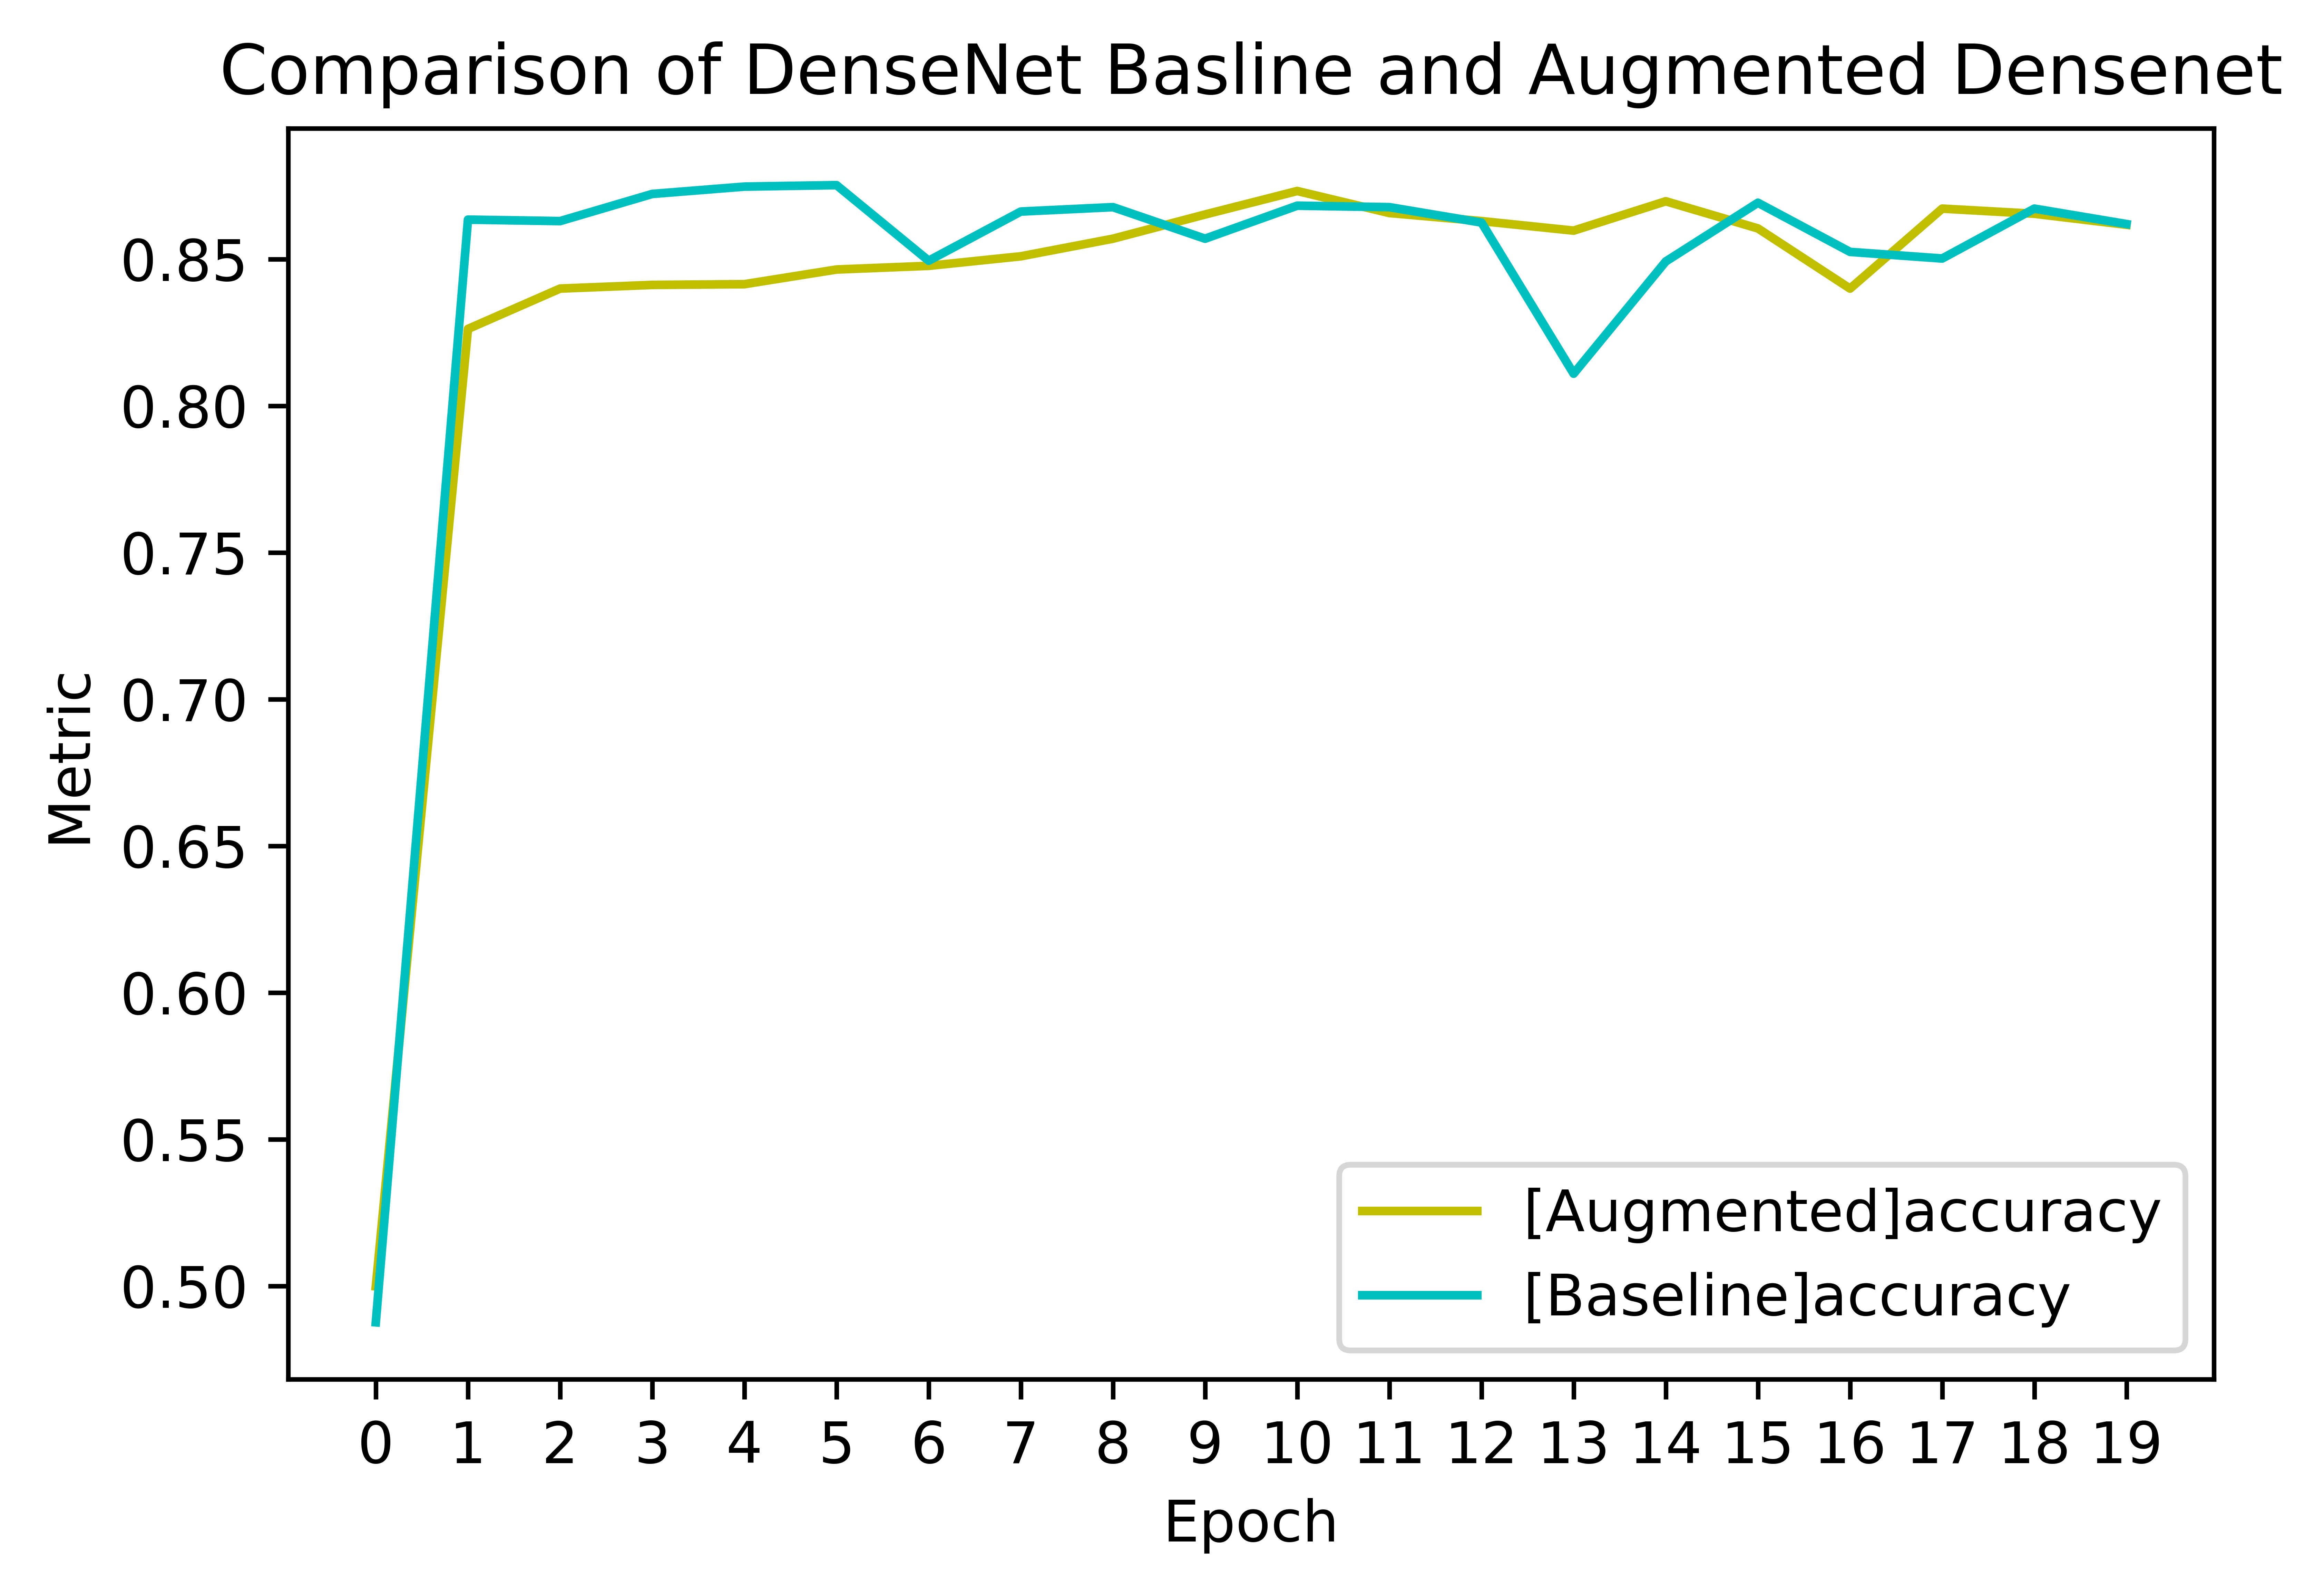

In [29]:
plt.figure(dpi=1200)

plt.ylabel('Metric')
plt.xlabel('Epoch')
plt.title('Comparison of DenseNet Basline and Augmented Densenet')

#plt.plot(np.arange(len(training_stats_Aug['tarining_loss'][0:20])), training_stats_Aug['tarining_loss'][0:20], 'y-', label='[Augmented]tarining loss')
#plt.plot(np.arange(len(training_stats_Aug['validation_loss'][0:20])), training_stats_Aug['validation_loss'][0:20], 'y--', label='[Augmented]validation loss')

#plt.plot(np.arange(len(training_stats_Base['tarining_loss'][0:20])), training_stats_Base['tarining_loss'][0:20], 'c-', label='[Baseline]tarining loss')
#plt.plot(np.arange(len(training_stats_Base['validation_loss'][1:21])), training_stats_Base['validation_loss'][1:21], 'c--', label='[Baseline]validation loss')

plt.xticks(np.arange(20))

#plt.legend()
#plt.show()

#plt.plot(np.arange(len(training_stats['accuracy'][0:21])), training_stats['accuracy'][0:21], label='accuracy')
#plt.plot(np.arange(len(training_stats['classification'])), training_stats['classification'], label='')
plt.plot(np.arange(20), training_stats_Aug['accuracy'][0:20], 'y-', label='[Augmented]accuracy')
#plt.plot(np.arange(20), [i[0] for i in training_stats_Aug['spearmanr']][0:20], 'y--', label="[Augmented]Spearman's rho")

plt.plot(np.arange(20), training_stats_Base['accuracy'][0:20], 'c-', label='[Baseline]accuracy')
#plt.plot(np.arange(20), [i[0] for i in training_stats_Base['spearmanr']][1:21], 'c--', label="[Baseline]Spearman's rho")

#print(np.array(training_stats['spearmanr']).max())
plt.legend()

plt.savefig('binary_metric.tif')

plt.show()

In [13]:
print(np.argmax(training_stats_Aug['accuracy']))

10


In [4]:
from Datasets import *

image_dir = r"I:\AVA_images"
pkl_dir= r"H:\AVAFeatures_pkl"
feature_dir = r'I:\AVA Featuremaps'
csv_dir = r"C:\Users\Leo's PC\Desktop\AVA.txt"
checkpoint_save_dir = r"C:\Users\Leo's PC\PycharmProjects\PD\Model Checkpoints"

Train = AVAFeatureDataset(csv_file=csv_dir, file_dir=feature_dir, pkl_dir=pkl_dir, start=0, end=255500, transform=transforms.Compose([Rescale_list((224, 224)), ToNumpy_list()]))

TypeError: __init__() missing 1 required positional argument: 'cache_folder'

In [1]:
for i in range(16, 20):
    print(i)

16
17
18
19


0.8939734933733433
0.8794698674668667


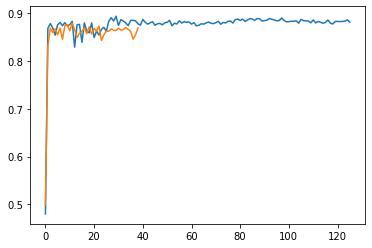

In [9]:
with open(r"C:\Users\Leo's PC\PycharmProjects\PD\Resource\Dense_StockV2_Final.pkl", 'rb') as fp:
    old_stock_Binary10 = pickle.load(fp)
    
with open(r"C:\Users\Leo's PC\PycharmProjects\PD\Resource\Dense_Augmented_E36_Binary10.pkl", 'rb') as fp:
    old_augmented_Binary10 = pickle.load(fp)
    
plt.figure()
plt.plot(old_stock_Binary10['accuracy'])
plt.plot(old_augmented_Binary10['accuracy'])

print(np.max(old_stock_Binary10['accuracy']))
print(np.max(old_augmented_Binary10['accuracy']))